# Personalized recommendation only for repeat buyers: training objective is always user → item preference, not item ↔ item co-occurrence.



item_similarity matrix is built from the user–item interaction matrix.
Each column is an item vector showing which users bought it (and how strongly, e.g. with log1p weights).
To compute similarity between two items, you compare those columns.
👉 So two items will have high cosine similarity if:
Many of the same users bought both, and
Their purchase patterns (weights) are similar.




### 🔹 User similarity (user–user CF)

* Two users are considered **similar** if they **interacted with the same items in similar ways**.
* You compare **rows** of the user–item matrix.
* Example: if Alice and Bob both bought mostly the same products, their vectors look alike → high similarity.

---

### 🔹 Item similarity (item–item CF)

* Two items are considered **similar** if they are **consumed by the same users**.
* You compare **columns** of the user–item matrix.
* Example: if product A and product B are often bought by the same customers, their vectors look alike → high similarity.
---

### 🔹 Concept in words

* **User similarity**: “Find other people who behave like me, then recommend what they bought.”
* **Item similarity**: “Find products that behave alike across customers, then recommend them to me based on what I bought.”


---

## 3. Item Embeddings

* Treat each basket (or order) like a “sentence” and each item like a “word.”
* Train embeddings with **Word2Vec/Skip-gram/CBOW** or newer methods.
* Similar items end up close in embedding space, which is often smoother and less sparse than co-purchase counts.

---

## 4. Bayesian/Probabilistic Models

* Models like **Bayesian Personalized Ranking (BPR)** or **Poisson Factorization** generate item similarity from a probabilistic perspective.
* These models are especially good for implicit feedback (purchases, clicks).

---

## 5. Hybrid Approaches

* Combine **collaborative signals** with **content similarity** (semantic embeddings, metadata).
* Example: If two items rarely co-occur but are textually or visually similar, hybrid scoring can still surface them.








If your goal is ranking items for recommendation (top-N lists) → Bayesian Personalized Ranking BPR-MF is the better choice than logistic. Better suited for recommendation lists where the order matters. BPR trains recommenders to rank bought items higher than not-bought items, using implicit feedback Learn the blend: train models (logistic, trees, or learning-to-rank) to set weights/features from data. MF + BPR loss → learns latent factors optimized for ranking (top-N recommendation). 

* **Blending:** final score $= \alpha \cdot \text{MF} + \beta \cdot \text{popularity} + \gamma \cdot \text{copurchase}$. Tune $\alpha,\beta,\gamma$ offline by NDCG\@K; verify with A/B.



* **General recipe:** A recommender = **model** (e.g., MF, linear regression, nearest-neighbor) + **parameters** (θ) + **loss/utility function** + **optimization algorithm**.
* **Training loop:**

  1. Use parameters → make predictions.
  2. Measure error/utility.
  3. Update parameters (e.g., gradient descent).
  4. Repeat until convergence.
* **Models:** can be global mean, bias models, linear regression, matrix factorization, etc.
* **Metrics to optimize:**

  * RMSE (prediction accuracy).
  * Classification accuracy (good vs. bad).
  * Ranking accuracy (top-N).
* **Optimization:** typically gradient descent (needs differentiable loss), sometimes EM or other iterative methods.

Ensembles win: Blend diverse models (MF, neighborhood, RBM, etc.) — a few strong ones often suffice. Many small, complementary predictors beat one “perfect” model.

* **Matrix setup:** Instead of ratings (1–5), use a **binary matrix**:

  * 1 if a user purchased an item.
  * 0 if not (missing/unknown).

* **Bias:** Biases first: Model global/user/item effects (means) — they matter a lot. Instead of rating means, the baseline becomes **popularity** (global, per-item, per-user purchase rates).

* **Normalization:** Center by subtracting these purchase probabilities (so frequent buyers or p\opular items don’t dominate).

* **Factorization:** Apply SVD/matrix factorization to this binary (or normalized) matrix → find latent factors of *why* items are co-purchased. Sparse-aware MF: Use matrix factorization that fits only observed entries (not dense SVD).

* **Scoring:** Predicted score = baseline purchase probability + user–item dot product in latent space.

  * High score = higher predicted likelihood of purchase.

* **Evaluation:**

  * Ratings → RMSE.
  * Purchases → ranking metrics (precision\@k, recall\@k, nDCG), since we only care about “what will the user buy next.”

👉 **Lesson:** It’s the same pipeline, but you swap “rating values” with “purchase indicators,” and evaluate with **ranking-based metrics** instead of rating accuracy.

Do you want me to give you a **1–2 sentence “purchase version” rewrite** of your original short learning list?

RMSE ≠ product impact: Ranking/top-N and online A/B tests are more aligned with business goals.


* Start with a big **user–item interaction matrix** (ratings, purchases, clicks).
* Initialize random **user vectors** ($p_u$) and **item vectors** ($q_i$).
* Define a **loss function** (e.g., squared error between actual vs predicted rating, or BPR for ranking).
* Use **optimization (like gradient descent)** to adjust the vectors so that:

  * items a user liked/bought get **higher predicted scores**,
  * items they ignored get **lower scores**.

👉 Over many updates, the vectors capture hidden patterns (“user likes sci-fi,” “item is a comedy”) so that the **dot product = predicted preference**.

In [53]:
import pandas as pd

cols = ['shopUserId', 'orderId', 'quantity', 'groupId', 'created']
tx = pd.read_csv('../data/processed//transactions_clean.csv', usecols=cols + ['status'], low_memory=False)
tx = tx[tx['status'] == 'active'][cols].astype({'quantity': int})
tx

,shopUserId,orderId,quantity,groupId,created
0,812427,785001,1,261873,2025-08-05 20:14:28
1,831360,784985,4,261745,2025-08-05 19:55:36
2,209204,784978,1,265298,2025-08-05 19:47:22
4,831340,784977,1,260596,2025-08-05 19:46:09
5,831340,784977,1,260596,2025-08-05 19:46:09
...,...,...,...,...,...
250024,78202,158870,1,221416,2024-05-22 14:18:16
250026,78181,158841,1,265843,2024-05-22 13:42:39
250038,78145,158800,1,261518,2024-05-22 12:54:51
250039,78136,158791,1,542087,2024-05-22 12:44:01


In [54]:
import numpy as np

# 0) sort (same-timestamp tie-breakers)
tx = tx.sort_values(["shopUserId","created","orderId","groupId"]).copy()

# 1) eligible users (≥2 interactions)
u_counts = tx.groupby("shopUserId")["groupId"].size()
eligible = u_counts[u_counts >= 3].index.values

# 2) disjoint cohorts
rng = np.random.default_rng(42)
TEST_FRAC, VAL_FRAC = 0.30, 0.30
test_users = set(rng.choice(eligible, size=int(len(eligible)*TEST_FRAC), replace=False))
remaining  = np.setdiff1d(eligible, list(test_users))
val_users  = set(rng.choice(remaining, size=int(len(remaining)*VAL_FRAC), replace=False))

# 3) last interaction per user
last_rows = tx.groupby("shopUserId", group_keys=False).tail(1)

test = last_rows[last_rows["shopUserId"].isin(test_users)].copy()
val  = last_rows[last_rows["shopUserId"].isin(val_users)].copy()
train = tx.drop(test.index.union(val.index)).copy()

# 4) safety: drop holdouts whose item never appears in TRAIN
seen = set(train["groupId"].unique())
val  = val[val["groupId"].isin(seen)].copy()
test = test[test["groupId"].isin(seen)].copy()

print("TRAIN:", train.shape, "VAL:", val.shape, "TEST:", test.shape)
print("Users — TRAIN:", train["shopUserId"].nunique(),
      "VAL:", val["shopUserId"].nunique(),
      "TEST:", test["shopUserId"].nunique())


TRAIN: (128887, 5) VAL: (3908, 5) TEST: (5588, 5)
Users — TRAIN: 57994 VAL: 3908 TEST: 5588


## Encode IDs on TRAIN only

In [55]:
from sklearn.preprocessing import LabelEncoder

u_le = LabelEncoder().fit(train["shopUserId"])
i_le = LabelEncoder().fit(train["groupId"])

val  = val [val ["shopUserId"].isin(u_le.classes_) & val ["groupId"].isin(i_le.classes_)]
test = test[test["shopUserId"].isin(u_le.classes_) & test["groupId"].isin(i_le.classes_)]

train = train.assign(user_idx=u_le.transform(train["shopUserId"]),
                     item_idx=i_le.transform(train["groupId"]))
val   = val.assign(user_idx=u_le.transform(val["shopUserId"]),
                   item_idx=i_le.transform(val["groupId"]))
test  = test.assign(user_idx=u_le.transform(test["shopUserId"]),
                    item_idx=i_le.transform(test["groupId"]))


## Build sparse matrices (binary) + BM25 KNN model

In [56]:

import numpy as np
from scipy.sparse import coo_matrix
from implicit.nearest_neighbours import BM25Recommender

UI = coo_matrix((np.ones(len(train)), (train.user_idx, train.item_idx))).tocsr()  # users×items
IU = UI.T.tocsr()                                                                 # items×users
UI_eval = IU.T.tocsr()                                                            # align with model

knn = BM25Recommender(K=50)  # you’ll tune K soon
knn.fit(IU)


/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0007288455963134766 seconds
  warnings.warn(


  0%|          | 0/57994 [00:00<?, ?it/s]

## Ground truth (one held-out item per user)

In [57]:
train_pos = train.groupby("user_idx")["item_idx"].apply(set).to_dict()
val_truth  = val.groupby("user_idx")["item_idx"].apply(set).to_dict()
test_truth = test.groupby("user_idx")["item_idx"].apply(set).to_dict()

## Recall@K helper

In [58]:
def recall_at_k(model, UI_eval, truth, K=10):
    hits = total = 0
    n_users = UI_eval.shape[0]
    for u, true in truth.items():
        if not (0 <= u < n_users):
            continue
        recs, _ = model.recommend(u, UI_eval[u], N=K, filter_already_liked_items=True)
        hits += len(set(recs) & true)
        total += len(true)
    return hits / max(total, 1)


## Tune just K on validation

In [59]:
# correct training loop
best = (None, -1.0)
for K in (20, 50, 100, 200):
    knn = BM25Recommender(K=K)
    knn.fit(IU)  # in-place; do NOT reassign

    score = recall_at_k(knn, UI_eval, val_truth, K=10)
    if score > best[1]:
        best = (K, score)

print("Best K:", best[0], "Val Recall@10:", round(best[1], 4))


/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0005855560302734375 seconds
  warnings.warn(


  0%|          | 0/57994 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00037741661071777344 seconds
  warnings.warn(


  0%|          | 0/57994 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00037169456481933594 seconds
  warnings.warn(


  0%|          | 0/57994 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00034928321838378906 seconds
  warnings.warn(


  0%|          | 0/57994 [00:00<?, ?it/s]

Best K: 20 Val Recall@10: 0.0


In [52]:
# merge train+val (binary dedup)
full = (pd.concat([train[["user_idx","item_idx"]],
                   val  [["user_idx","item_idx"]]], ignore_index=True)
          .drop_duplicates()
          .assign(x=1.0))
UI_full  = coo_matrix((full.x, (full.user_idx, full.item_idx))).tocsr()
IU_full  = UI_full.T.tocsr()
UIe_full = IU_full.T.tocsr()

knn = BM25Recommender(K=best[0]).fit(IU_full)
test_recall10 = recall_at_k(knn, UIe_full, test_truth, K=10)
print("Test Recall@10:", round(test_recall10, 4))


/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0007426738739013672 seconds
  warnings.warn(


  0%|          | 0/57994 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'recommend'

In [ ]:
pop = np.argsort(-UI_eval.sum(axis=0).A1)
def pop_recall_at_k(K=10):
    hits=tot=0
    for u, true in val_truth.items():
        recs = [i for i in pop if i not in train_pos.get(u, set())][:K]
        hits += len(set(recs) & true); tot += len(true)
    return hits/max(tot,1)
print("Popularity Val Recall@10:", round(pop_recall_at_k(10), 4))


In [3]:
import numpy as np

# --- compute IDF on train only ---
user_per_item = train.groupby("groupId")["shopUserId"].nunique()
N_users = train["shopUserId"].nunique()
idf = np.log1p(N_users / (1.0 + user_per_item))

# --- apply TF * IDF ---
def add_weights(df):
    df = df.copy()
    df = df.merge(idf.rename("idf"), on="groupId", how="left")
    df["interaction"] = np.log1p(df["quantity"]) * df["idf"]
    return df

train = add_weights(train)
val = add_weights(val)
test  = add_weights(test)

In [4]:
train

,shopUserId,orderId,quantity,groupId,created,idf,interaction
0,78181,158841,1,265843,2024-05-22 13:42:39,4.288121,2.972299
1,78181,631793,1,265823,2025-03-20 13:32:48,6.427674,4.455324
2,78181,631793,1,270794,2025-03-20 13:32:48,6.783864,4.702216
3,78181,631793,1,263855,2025-03-20 13:32:48,4.323148,2.996578
4,78182,307897,1,291625,2024-09-17 11:30:56,5.310418,3.680901
...,...,...,...,...,...,...,...
45466,831087,784699,1,265298,2025-08-05 15:11:28,3.672967,2.545907
45467,831138,784753,2,291252,2025-08-05 16:12:48,4.858314,5.337404
45468,831138,784753,1,210773,2025-08-05 16:12:48,8.035818,5.570005
45469,831184,784801,1,261427,2025-08-05 16:44:36,4.166134,2.887744


In [195]:
# aggregate with sum
train = train.groupby(["shopUserId","groupId"], as_index=False)["interaction"].sum()
val   = val.groupby(["shopUserId","groupId"],   as_index=False)["interaction"].sum()
test  = test.groupby(["shopUserId","groupId"],  as_index=False)["interaction"].sum()

#cap = train["interaction"].quantile(0.99)
#train["interaction"] = train["interaction"].clip(upper=cap)
#val["interaction"]   = val["interaction"].clip(upper=cap)
#test["interaction"]  = test["interaction"].clip(upper=cap)

In [196]:
train

,shopUserId,groupId,interaction
0,79265,210186,1.477531
1,79265,210338,1.209708
2,79265,242024,2.793249
3,79265,260646,1.305010
4,79265,260695,1.449191
...,...,...,...
928,674430,261699,1.885429
929,674430,265041,1.608156
930,683096,210338,6.048539
931,683096,221416,8.727666


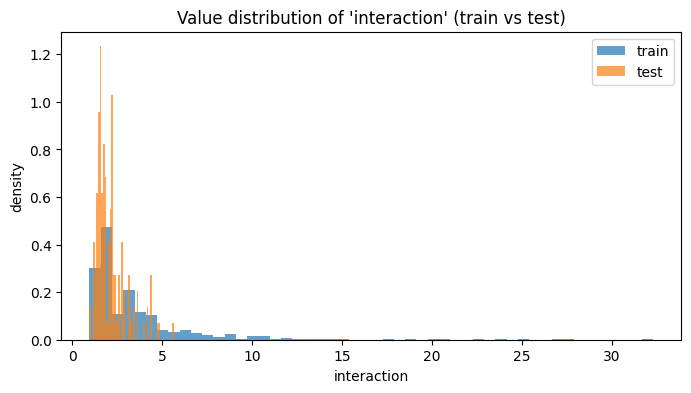

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(train["interaction"], bins=50, alpha=0.7, label="train", density=True)
plt.hist(test["interaction"], bins=50, alpha=0.7, label="test", density=True)
plt.xlabel("interaction")
plt.ylabel("density")
plt.title("Value distribution of 'interaction' (train vs test)")
plt.legend()
plt.show()


## creat labels for further mf 

In [198]:
from sklearn.preprocessing import LabelEncoder

# --- fit encoders on TRAIN only ---
user_enc = LabelEncoder().fit(train["shopUserId"])
item_enc = LabelEncoder().fit(train["groupId"])

# --- filter val/test to drop unseen users/items ---
val  = val[val["shopUserId"].isin(user_enc.classes_) & val["groupId"].isin(item_enc.classes_)]
test = test[test["shopUserId"].isin(user_enc.classes_) & test["groupId"].isin(item_enc.classes_)]

# --- transform all splits ---
train["user_idx"] = user_enc.transform(train["shopUserId"])
train["item_idx"] = item_enc.transform(train["groupId"])

val["user_idx"]   = user_enc.transform(val["shopUserId"])
val["item_idx"]   = item_enc.transform(val["groupId"])

test["user_idx"]  = user_enc.transform(test["shopUserId"])
test["item_idx"]  = item_enc.transform(test["groupId"])

## quick lookup dicts for later

In [199]:
uid2idx = dict(zip(user_enc.classes_, user_enc.transform(user_enc.classes_)))
iid2idx = dict(zip(item_enc.classes_, item_enc.transform(item_enc.classes_)))


## Build the sparse interaction matrix

In [200]:
from scipy.sparse import coo_matrix

# Build user–item from TRAIN
UI = coo_matrix(
    (train["interaction"].astype(float), (train["user_idx"], train["item_idx"]))
).tocsr()

# Item–user for training
IU = UI.T.tocsr()

# User–item for evaluation (always the transpose of IU)
UI_eval = IU.T.tocsr()

assert UI_eval.shape[0] == IU.shape[1]   # sanity: same user dimension

UI.shape, IU.shape

((156, 81), (81, 156))

In [185]:
# must run AFTER encoding train/val/test with encoders fit on TRAIN
train_pos = train.groupby("user_idx")["item_idx"].apply(set).to_dict()
val_truth = val.groupby("user_idx")["item_idx"].apply(set).to_dict()
test_truth = test.groupby("user_idx")["item_idx"].apply(set).to_dict()

# optional guard — align with training matrix dimensions
n_users = IU.shape[1]          # same as UI_eval.shape[0]
val_truth  = {u: s for u, s in val_truth.items()  if 0 <= u < n_users}
test_truth = {u: s for u, s in test_truth.items() if 0 <= u < n_users}

# sanity
assert set(val_truth.keys()).issubset(train_pos.keys())
assert set(test_truth.keys()).issubset(train_pos.keys())

In [186]:
# --- hyperparameter grid ---
grid = {
    "factors": [32, 64, 96],
    "regularization": [0.003, 0.01, 0.03],
    "learning_rate": [0.03, 0.05, 0.08],
    "iterations": [30, 60, 100],
}


In [187]:
from itertools import product
from implicit.bpr import BayesianPersonalizedRanking

def recall_at_k(model, UI_eval, truth, K=10):
    hits = total = 0
    n_users_model = model.user_factors.shape[0]  # authoritative size
    for u, true_items in truth.items():
        if not (0 <= u < n_users_model):
            continue
        recs, _ = model.recommend(u, UI_eval[u], N=K, filter_already_liked_items=True)
        hits += len(set(recs) & true_items)
        total += len(true_items)
    return hits / max(total, 1)

# --- grid search with validation ---
best = (None, float('-inf'))  # Initialize best as (params, score) with lowest possible score
for f, reg, lr, it in product(grid["factors"],
                              grid["regularization"],
                              grid["learning_rate"],
                              grid["iterations"]):
    model = BayesianPersonalizedRanking(
        factors=f, regularization=reg, learning_rate=lr, iterations=it
    )
    model.fit(IU)  # train on TRAIN only
    score = recall_at_k(model, UI_eval, val_truth, K=10)  # use only validation here
    if score > best[1]:
        best = ({"factors": f, "regularization": reg,
                 "learning_rate": lr, "iterations": it}, score)

print("Best on VAL:", best[0], "Recall@10 =", round(best[1], 4))


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Best on VAL: {'factors': 32, 'regularization': 0.01, 'learning_rate': 0.05, 'iterations': 100} Recall@10 = 0.0864


In [188]:
import pandas as pd
from scipy.sparse import coo_matrix

# 0) Merge TRAIN+VAL (indices already from train-fitted encoders)
full = pd.concat(
    [train[["user_idx","item_idx","interaction"]],
     val[["user_idx","item_idx","interaction"]]],
    ignore_index=True
)

# 1) Make interactions binary & drop dupes
full = full.drop_duplicates(subset=["user_idx","item_idx"]).assign(interaction=1.0)

# 2) Build matrices (users × items) and its transpose (items × users)
UI_full = coo_matrix((full["interaction"], (full["user_idx"], full["item_idx"]))).tocsr()
IU_full = UI_full.T.tocsr()
UI_eval_full = IU_full.T.tocsr()  # guarantees row indexing matches model.user_factors

# 3) Retrain BPR on TRAIN+VAL with the best params found on VAL
best_params = {"factors": 64, "regularization": 0.003, "learning_rate": 0.03, "iterations": 30}
from implicit.bpr import BayesianPersonalizedRanking
model = BayesianPersonalizedRanking(**best_params)
model.fit(IU_full)

# 4) Evaluate HIT RATE / RECALL@K on TEST (K=10)
def recall_at_k(model, UI_eval, truth, K=10):
    hits = total = 0
    n_users = model.user_factors.shape[0]
    for u, true_items in truth.items():
        if not (0 <= u < n_users):  # safety (shouldn't trigger)
            continue
        recs, _ = model.recommend(u, UI_eval[u], N=K, filter_already_liked_items=True)
        hits += len(set(recs) & true_items)
        total += len(true_items)
    return hits / max(total, 1)

test_hit_at_10 = recall_at_k(model, UI_eval_full, test_truth, K=10)
print(f"Test HitRate@10: {test_hit_at_10:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Test HitRate@10: 0.0247
